### Estimating ODE parameters: yeast data and the logistic equation
We will model the growth of yeast in a petri dish using the logistic equation
$$\frac{du}{dt} = au(1-u/K)$$
This equation models the population $u(t)$ of a species which grows exponentially with growth rate $a>0$ for small populations and lives in an environment that can sustain populations up to a carrying capacity $K>0$. We will load experimental data published in `Tor Carlson: "Über Geschwindigkeit und Größe der Hefevermehrung in Würze", Biochemische Zeitschrift 57 (1913) 313–334` into this notebook and see whether we can choose the initial condition $u(0)$ and the model parameters $a$ and $K$ to match the experimental data. We will first try to fit the parameters by hand and then use a parameter fitting routine to accomplish this task.

The next cell loads several modules needed for defining f(x) and for running the code. To proceed, click twice on the run button (the triangle in the top menubar) to run the current and the next cell.

In [1]:
%matplotlib widget
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

We can now load the experimental yeast data.

In [2]:
# Load yeast data
Yeast = np.loadtxt(open('Yeast_Data_Carlson_1913.txt', "rb"), skiprows=1)

In [3]:
def apply_qualitative_theory(f, data, *pars):
    tmax = 20
    xmin = 0
    xmax = 700
    xplot = np.arange(xmin, xmax, (xmax-xmin)/1000)
    fplot = f(0, xplot, *pars)
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3.5))
    ax[0].set_title("Graph of f(u)")
    ax[0].set_xlabel('u')
    ax[0].set_ylabel('f(u)')
    ax[0].axhline(y=0, c='grey', linewidth=0.5)
    ax[0].set_xlim(xmin, xmax)
    ax[1].set_title("Solutions as functions of time")
    ax[1].set_xlabel('time t')
    ax[1].set_ylabel('u')
    ax[1].set_xlim(0, tmax)
    ax[1].set_ylim(xmin, xmax)
    ax[1].axvline(x=0, c='grey', linewidth=0.5)
    ax[1].scatter(data[:, 0], data[:, 1], c='tab:olive', s=50, marker='o')
    ax[0].plot(xplot, fplot, color='tab:green')
    plt.tight_layout()
    plt.show()

    def solve_ode(t, x):
        tf = np.linspace(t, tmax, 100)
        tb = np.linspace(t, 0, 100)
        solf = solve_ivp(f, [t, tmax], [x], args=pars, t_eval=tf, atol=1.0e-6, rtol=1.0e-4)
        solb = solve_ivp(f, [t, 0],    [x], args=pars, t_eval=tb, atol=1.0e-6, rtol=1.0e-4)
        ax[1].plot(solf.t, solf.y[0], color='tab:blue', alpha=0.8)
        ax[1].plot(solb.t, solb.y[0], color='tab:blue', alpha=0.8)
        plt.show()

    def on_click(event):
        global toggle, labels
        if event.button is MouseButton.LEFT:
            if event.inaxes == ax[0]:
                x = event.xdata
                if x>xmin and x<xmax:
                    equilibrium = fsolve(lambda x: f(0, x, *pars), x)
                    ax[0].scatter(equilibrium, 0, c='tab:red', s=50, marker='o')
                    ax[1].axhline(y=equilibrium, c='tab:red')
            elif event.inaxes == ax[1]:
                t = event.xdata
                x = event.ydata
                if x>xmin and x<xmax: solve_ode(t, x)
        fig.canvas.draw()
    
    plt.connect('button_press_event', on_click)

The following cell defines the logistic equation $f(u)=au(1-u/K)$ of our differential equation. Click again twice on the run button to execute this and the next cell. The code will create two figures side by side.

* The left figure shows the graph of f(u). If you click close to a root of f(u) in the left figure, the code will compute the equilibrium and plot it.
* The right figure shows the yeast data in olive as well as solution graphs. Position your mouse anywhere in the right figure: if you click on the figure, the code will compute and plot the solution that starts at the (t,u) location of your mouse. Try it out a few times to see what happens when you click at different points in the right figure!

You can go back to this cell after running the next cell by clicking on the gray area containing the `def rhs(t, u, a, K):` statement: this allows you to edit the values for the parameters a and K.

<IPython.core.display.Javascript object>


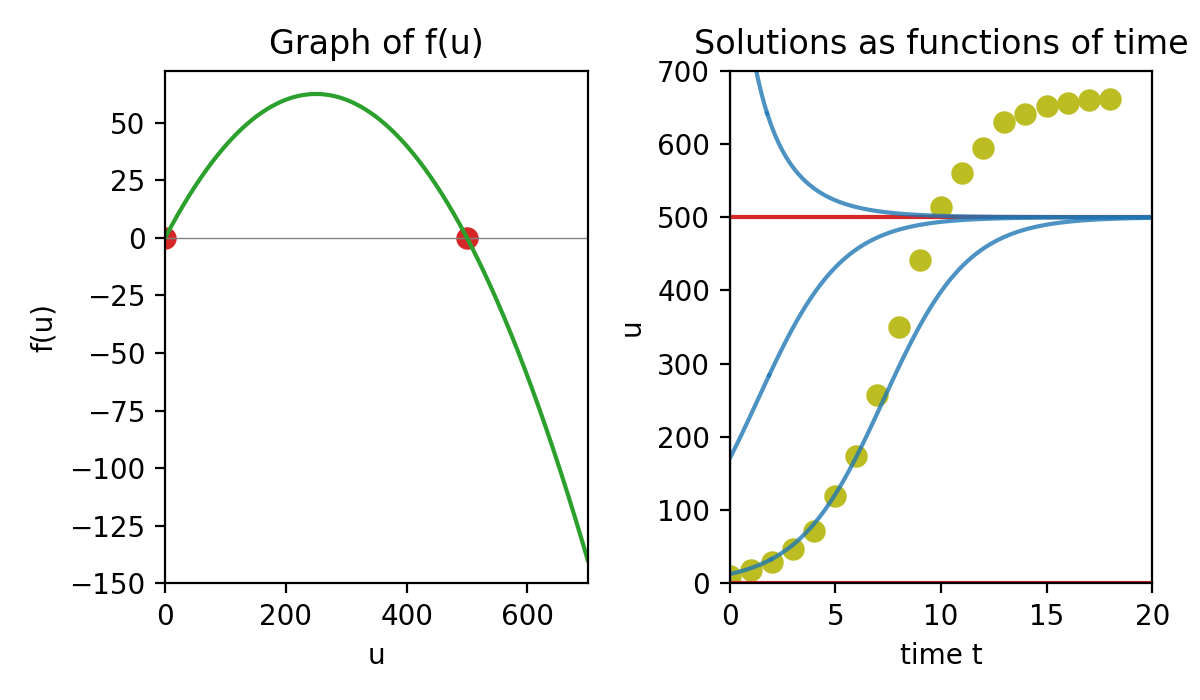

In [4]:
# Define rhs
def rhs(t, u, a, K):
    return a*u*(1-u/K)

# Run qualitative tool
apply_qualitative_theory(rhs, Yeast, 0.5, 500)

The code on the following cell will fit the parameters a and K of the model to the yeast data and plot the resulting solution of the logistic model.

<IPython.core.display.Javascript object>


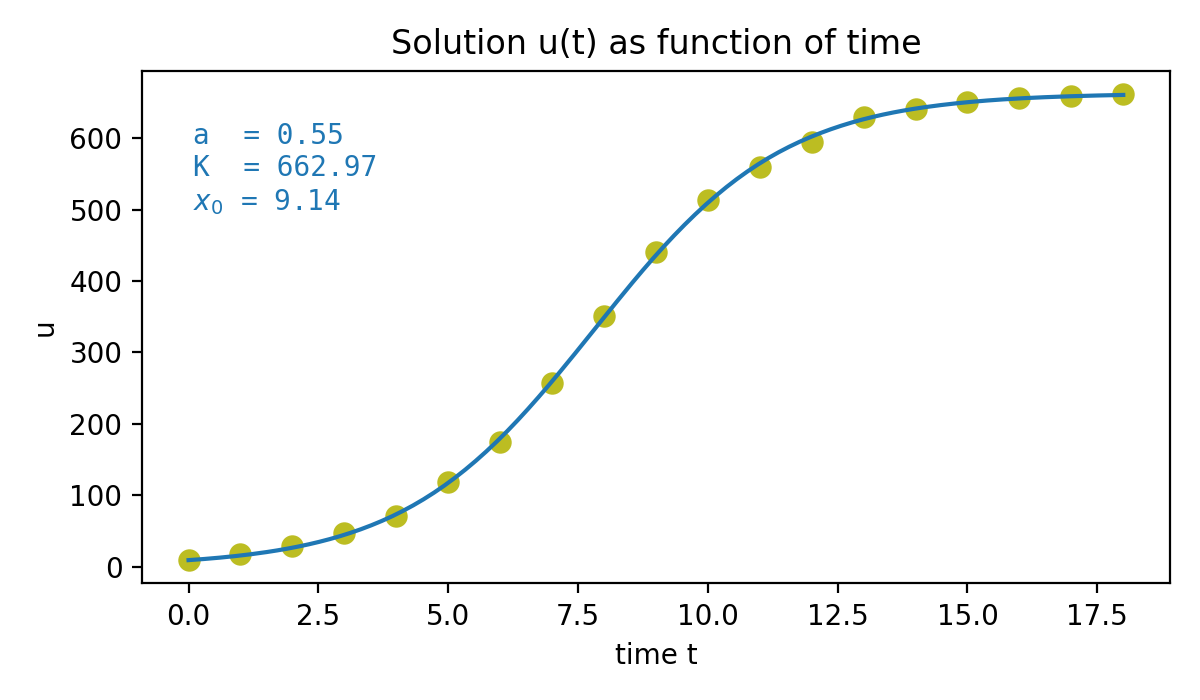

In [5]:
# Integrate ODE
def solveModel(t, a, K, x0):
    soln = solve_ivp(rhs, [0, 18], [x0], t_eval=t, args=(a, K))
    return soln.y[0]

# Set data to fit
x0 = 15
data_time = Yeast[:, 0]
data_yeast = Yeast[:, 1]

# Fit parameters
vals, cov = curve_fit(solveModel, data_time, data_yeast, p0=[0.5, 500, x0])
label = 'a  = {:.2f}\nK  = {:.2f}\n$x_0$ = {:.2f}'.format(vals[0], vals[1], vals[2])

# Compute fitted solution
t = np.linspace(0, 18, 180)
x = solveModel(t, vals[0], vals[1], vals[2])

# Plot fitted solution
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
plt.title("Solution u(t) as function of time")
plt.xlabel('time t')
plt.ylabel('u')
plt.text(0.05, 0.9, label,
         verticalalignment='top', horizontalalignment='left',
         transform=ax.transAxes,
         color='tab:blue', fontsize=10, fontfamily='monospace')
plt.scatter(data_time, data_yeast, c='tab:olive', s=50, marker='o')
plt.plot(t, x, color='tab:blue')
plt.tight_layout()
plt.show()